In [ ]:
#What is the causal impact of including free shipping on trial membership activation?

In [2]:
import pandas as pd
import numpy as np

In [3]:
#Set random seed for reproducibility
np.random.seed(42)

# Generate data for analysis
data = {
    "user_id": np.random.uniform(10000, 50000, size=50000), 
    "membership_conversion": np.random.choice([0, 1], size=50000, p=[0.8, 0.2]),  # Output variable
    "avail_free_shipping": np.random.choice([0, 1], size=50000, p=[0.5, 0.5]),  # Treatment Variable
    "annual_purchase_value": np.random.uniform(10, 10000, size=50000),  # Numeric input variable
    "membership_plan": np.random.choice(["monthly", "annual"], size=50000, p=[0.8, 0.2]),  # Discrete variable
    "session_activity": np.random.uniform(1, 10, size=50000)  # Continuous variable   
}
df = pd.DataFrame(data)

# Create a DataFrame and transform the attributes for score generation

df['user_id'] = df['user_id'].astype(int)
df['annual_purchase_value'] = df['annual_purchase_value'].astype(int)
df['session_activity'] = df['session_activity'].astype(int)
#drop_first=True removes one category to avoid multicollinearity (e.g., only Plan_Type_annual is added).
df_encoded = pd.get_dummies(df, columns=['membership_plan'], drop_first=True)
df_encoded['membership_plan_monthly'] = df_encoded['membership_plan_monthly'].astype(int)

In [4]:
# df.user_id.nunique()
df_encoded.head(10)

,user_id,membership_conversion,avail_free_shipping,annual_purchase_value,session_activity,membership_plan_monthly
0,24981,1,1,701,9,1
1,48028,0,1,5861,1,1
2,39279,0,0,7990,2,1
3,33946,0,0,7647,6,1
4,16240,0,0,8375,4,1
5,16239,0,1,9794,5,1
6,12323,0,1,9958,3,1
7,44647,0,1,4110,6,0
8,34044,0,0,5025,1,1
9,38322,0,1,4986,2,1


In [5]:
df.groupby(["membership_conversion","avail_free_shipping"])["avail_free_shipping"].count()
df.groupby(["membership_conversion","membership_plan"])["user_id"].nunique()

membership_conversion  membership_plan
0                      annual              7337
                       monthly            21845
1                      annual              1873
                       monthly             7328
Name: user_id, dtype: int64

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [ ]:
#Estimate Propensity Scores of probability of a user availing free shipping (i.e. treatment)

In [7]:
df_psm=df_encoded
df_psm=df_psm.rename(columns={"avail_free_shipping": "Treatment"})
# Standardize numeric covariates
scaler = StandardScaler()
df_psm[['annual_purchase_value_scaled', 'session_activity_scaled']] = scaler.fit_transform(df_psm[['annual_purchase_value', 'session_activity']])
# Define covariates and treatment
covariates = df_psm[['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']]
treatment = df_psm['Treatment']
# Logistic regression to estimate propensity scores
logistic_model = LogisticRegression()
logistic_model.fit(covariates, treatment)
df_psm['Propensity_Score'] = logistic_model.predict_proba(covariates)[:, 1]

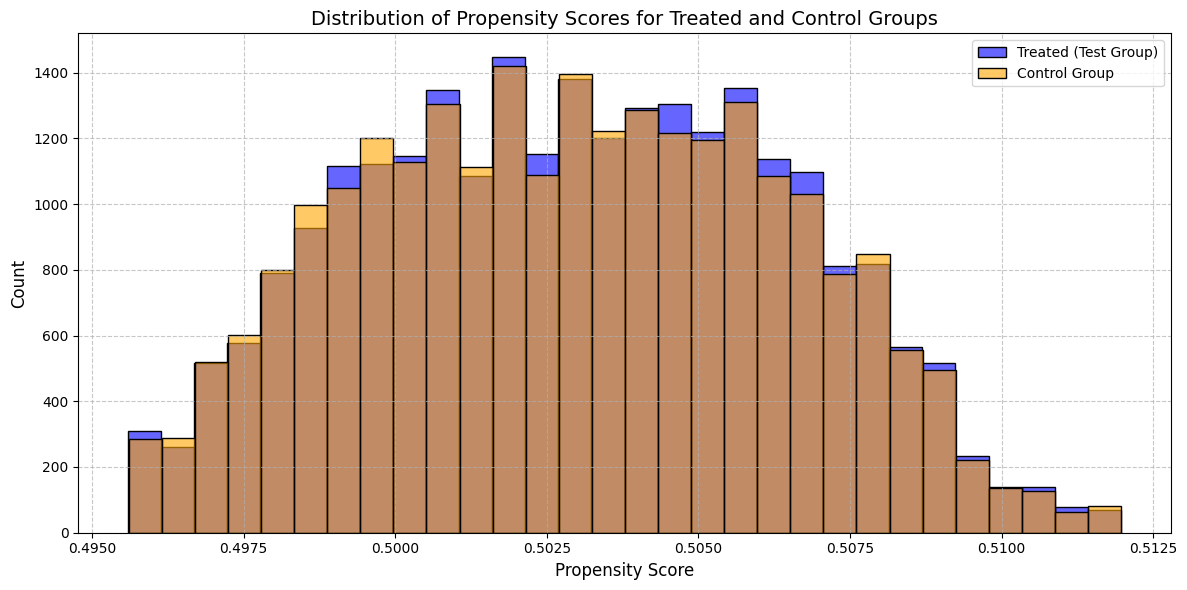

In [8]:
# Create separate data for treated and control groups
import matplotlib.pyplot as plt
import seaborn as sns 

treated = df_psm[df_psm['Treatment'] == 1]
control = df_psm[df_psm['Treatment'] == 0]

# Plot propensity score distributions for treated and control groups
plt.figure(figsize=(12, 6))

# Bar plot for treated group
sns.histplot(treated['Propensity_Score'], bins=30, label='Treated (Test Group)', color='blue', alpha=0.6, kde=False)

# Bar plot for control group
sns.histplot(control['Propensity_Score'], bins=30, label='Control Group', color='orange', alpha=0.6, kde=False)

# Add labels, title, and legend
plt.title('Distribution of Propensity Scores for Treated and Control Groups', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
Distribution of Propensity Scores (Post-Matching)

X-Axis (Propensity Score):
Represents the probability of a user receiving the treatment (i.e., being in the test group), calculated using observed covariates.

Y-Axis (Count):
Shows how many users fall into each propensity score bin.

Overlap Between Treated and Control Groups
	•	The plot shows a high degree of overlap between the Treated (blue) and Control (orange) groups across nearly all bins.
	•	Most overlap is concentrated around 0.500 to 0.506, which indicates that both groups share similar characteristics after matching.
	•	This suggests the matching algorithm has successfully balanced the covariates between the two groups.

Gaps in Distribution
	•	A small dip appears around 0.5035, where both groups show a slight reduction in count.
	•	This might be due to the natural sparsity of data in that score range, or the removal of unmatched samples during the 
matching process.

📉 Differences in Bar Heights
	•	There are minor differences in group sizes across bins, especially in the tails (e.g., below 0.498 or above 0.508).
	•	These slight imbalances are expected and acceptable post-matching, as most users cluster around the middle range where 
overlap is strongest.

Implications
	•	Successful Matching: Strong overlap between treated and control users indicates well-balanced groups, minimizing selection bias 
and improving causal estimation.
	•	Sample Exclusion:The sparse regions might reflect users dropped due to poor matches, 
which is a standard part of Propensity Score Matching (PSM).
	•	Balanced Dataset:Overall, the distribution suggests that the dataset is well-balanced 
and ready for downstream treatment effect analysis.

In [ ]:
#Perform Matching

In [9]:
# Split data into treated and control groups
treated = df_psm[df_psm['Treatment'] == 1]
control = df_psm[df_psm['Treatment'] == 0]

# Match treated units to control units using nearest neighbor matching on propensity scores and in form of balls (clusters) 
#for efficient matching. Used in high dimension data(i.e. multiple covariates) and high no of data points
matcher = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
matcher.fit(control[['Propensity_Score']])
distances, indices = matcher.kneighbors(treated[['Propensity_Score']])

# Get matched control indices
matched_control_indices = control.iloc[indices.flatten()].index

# Create matched dataset
matched_df = pd.concat([treated, control.loc[matched_control_indices]])

print(f"Matched Dataset Size: {matched_df.shape[0]} rows")

Matched Dataset Size: 50298 rows


In [10]:
# Compare covariate means before and after matching
before_matching = df_psm.groupby('Treatment')[['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']].mean()
after_matching = matched_df.groupby('Treatment')[['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']].mean()

# print("Covariate Means Before Matching:")
# print(before_matching)

# print("\nCovariate Means After Matching:")
# print(after_matching)

print(f"Covariate Means Before Matching: {before_matching.to_string()} | Covariate Means After Matching: {after_matching.to_string()}")

Covariate Means Before Matching:            annual_purchase_value_scaled  session_activity_scaled  membership_plan_monthly
Treatment                                                                                
0                             -0.002392                 0.006143                 0.800692
1                              0.002364                -0.006070                 0.798998 | Covariate Means After Matching:            annual_purchase_value_scaled  session_activity_scaled  membership_plan_monthly
Treatment                                                                                
0                             -0.007842                -0.013211                 0.802656
1                              0.002364                -0.006070                 0.798998


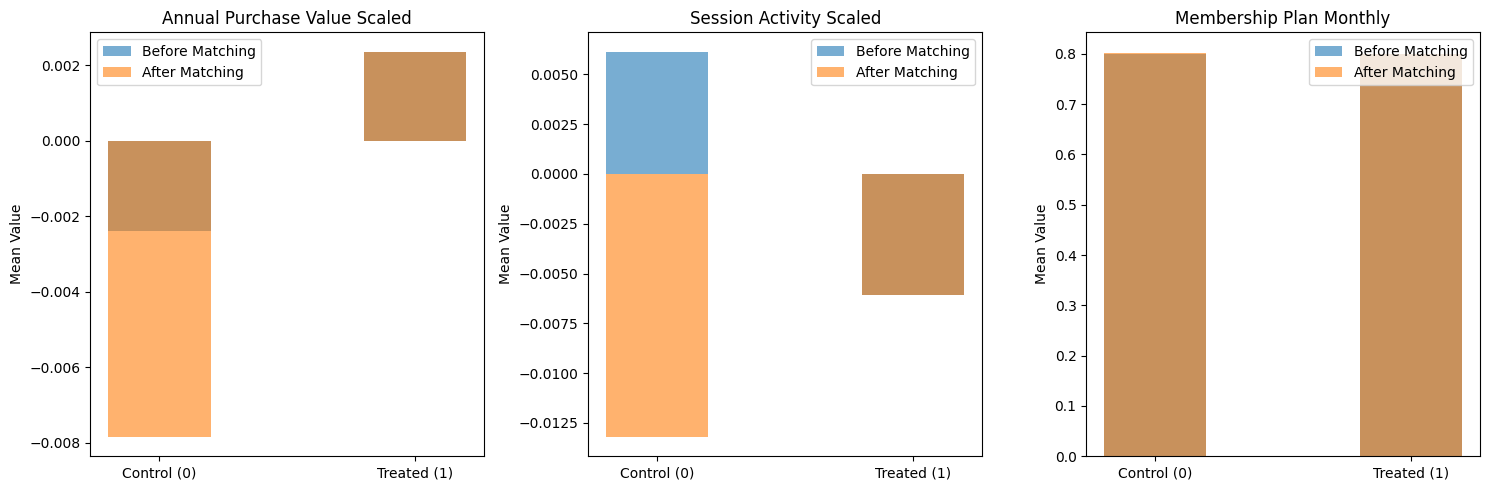

In [11]:
#Visualize the matching results 
import matplotlib.pyplot as plt

# Prepare data
covariates = ['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly']
treatment_labels = ['Control (0)', 'Treated (1)']

fig, axes = plt.subplots(1, len(covariates), figsize=(15, 5))

for idx, covariate in enumerate(covariates):
    before = before_matching[covariate]
    after = after_matching[covariate]
    
    axes[idx].bar(treatment_labels, before, width=0.4, label='Before Matching', alpha=0.6)
    axes[idx].bar(treatment_labels, after, width=0.4, label='After Matching', alpha=0.6, bottom=before*0)
    
    axes[idx].set_title(covariate.replace('_', ' ').title())
    axes[idx].set_ylabel('Mean Value')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [12]:
#Evaluate Balance:
#SMD measures the difference in means of a covariate between treated and control groups, scaled by the pooled standard deviation.
def calculate_smd(df, treatment_col, covariates):
    smd_results = []

    # Separate treated and control groups
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]

    for covariate in covariates:
        # Mean and variance for treated and control groups
        mean_treated = treated[covariate].mean()
        mean_control = control[covariate].mean()
        var_treated = treated[covariate].var()
        var_control = control[covariate].var()

        # Calculate pooled standard deviation
        pooled_std = np.sqrt((var_treated + var_control) / 2)

        # Calculate SMD
        smd = (mean_treated - mean_control) / pooled_std
        smd_results.append({'Covariate': covariate, 'SMD': smd})

    return pd.DataFrame(smd_results)

# Example usage
smd_df_orig = calculate_smd(df_psm, 'Treatment', ['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly'])

# Display the SMD results
print(smd_df_orig)

smd_df_matched = calculate_smd(matched_df, 'Treatment', ['annual_purchase_value_scaled', 'session_activity_scaled', 'membership_plan_monthly'])

# Display the SMD results
print(smd_df_matched)


                      Covariate       SMD
0  annual_purchase_value_scaled  0.004756
1       session_activity_scaled -0.012213
2       membership_plan_monthly -0.004234
                      Covariate       SMD
0  annual_purchase_value_scaled  0.010233
1       session_activity_scaled  0.007138
2       membership_plan_monthly -0.009160


In [ ]:
Interpret output of SMD of matched pairs

Thresholds for Good Balance:
	•	SMD < 0.1: Excellent balance.
	•	SMD < 0.2: Acceptable balance.
	•	SMD >= 0.2: Imbalance exists.

Overall Observations
After Matching:
	•	Balance is further improved, as SMD values are reduced (closer to 0) or maintained.
	•	This indicates the matching process successfully aligned the treated and control groups.

In [14]:
# Split data into treated and control groups
treated = df_psm[df_psm['Treatment'] == 1]  # Treated group
control = df_psm[df_psm['Treatment'] == 0]  # Control group

# Fit Nearest Neighbors on control group propensity scores
matcher = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
matcher.fit(control[['Propensity_Score']])

# Match treated units to nearest control units
distances, indices = matcher.kneighbors(treated[['Propensity_Score']])

# Extract indices of matched pairs
treated_indices = treated.index
control_indices = control.iloc[indices.flatten()].index

# Create a DataFrame of matched pairs
matched_pairs = pd.DataFrame({
    'Treated_User_ID': treated['user_id'].values,
    'Control_User_ID': control.loc[control_indices, 'user_id'].values,
    'Treated_Propensity_Score': treated['Propensity_Score'].values,
    'Control_Propensity_Score': control.loc[control_indices, 'Propensity_Score'].values,
    'Propensity_Score_Difference': abs(
        treated['Propensity_Score'].values - 
        control.loc[control_indices, 'Propensity_Score'].values
    )
})

# Save and display the matched pairs
# import ace_tools as tools; tools.display_dataframe_to_user(name="Matched Pairs from Propensity Score Matching", dataframe=matched_pairs)

matched_pairs.head() 

,Treated_User_ID,Control_User_ID,Treated_Propensity_Score,Control_Propensity_Score,Propensity_Score_Difference
0,24981,34664,0.495879,0.495879,0.000000e+00
1,48028,47003,0.507577,0.507577,6.469684e-07
2,16239,13490,0.504421,0.504421,0.000000e+00
3,12323,25945,0.506880,0.506880,0.000000e+00
4,44647,17249,0.503570,0.503569,5.931299e-07


In [16]:
matched_pairs.shape

(25149, 5)

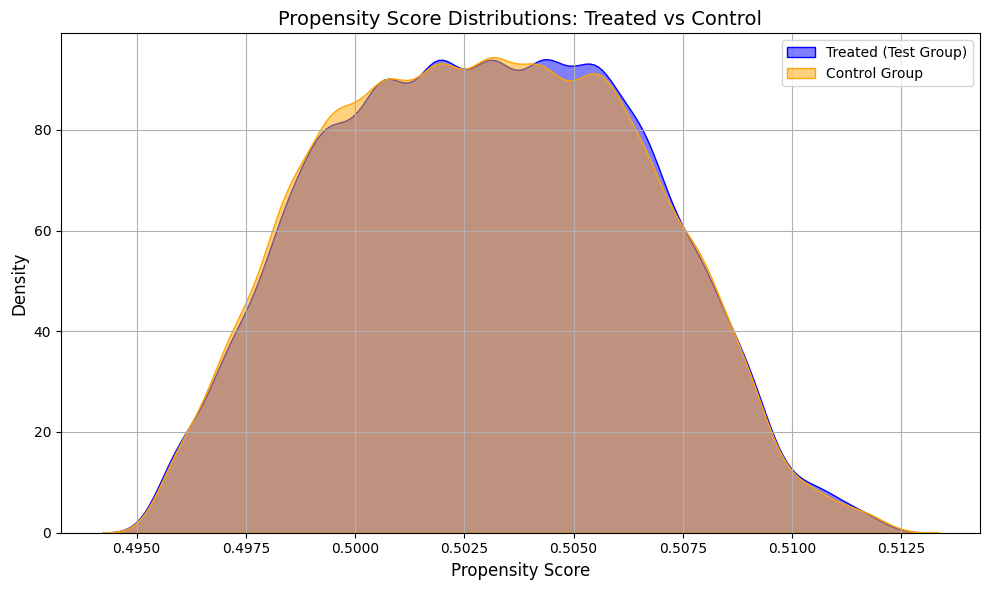

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` contains 'Propensity_Score' and 'Paramount_activation' columns
# Create separate data for treated and control groups
treated = df_psm[df_psm['Treatment'] == 1]  # Treated group
control = df_psm[df_psm['Treatment'] == 0]  # Control group

# Plot propensity score distributions for treated and control groups
plt.figure(figsize=(10, 6))
sns.kdeplot(treated['Propensity_Score'], label='Treated (Test Group)', fill=True, color='blue', alpha=0.5)
sns.kdeplot(control['Propensity_Score'], label='Control Group', fill=True, color='orange', alpha=0.5)

# Add labels and title
plt.title('Propensity Score Distributions: Treated vs Control', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
1. Overlap Between Treated and Control Groups
	•	There is a significant overlap between the treated and control group distributions for propensity scores.
	•	This overlap indicates that the matching process was successful in ensuring comparability between the two groups.
	•	Both distributions are concentrated within a similar range of propensity scores (around 0.502 to 0.505).
2. Distinct Peaks
	•	The Control Group (orange curve) and Treated Group (blue curve) have very similar density patterns, 
with their peaks overlapping closely.
	•	However, there is a slight difference in heights of the curves, suggesting that there may be slightly more data points in the control group for certain ranges of propensity scores.
3. Propensity Score Range
	•	The propensity scores for both groups are within a narrow range (approximately 0.502 to 0.505), indicating tight matching.
	•	The gap around 0.5035 could represent a region where fewer individuals exist, which may be due to how the propensity scores were distributed during the matching process.
4. Minimal Non-Overlap
	•	The degree of non-overlap (e.g., areas where one group has density but the other does not) is negligible. This is ideal as it ensures that there are control matches for almost all treated units.
5. Implications
	•	Good Balance: The high degree of overlap suggests that the treated and control groups are well-matched in terms of their covariates (used to calculate propensity scores).
	•	Minor Gap: The slight difference in curve density in some regions (e.g., around 0.5045) indicates a small imbalance but is unlikely to have a significant impact on the analysis.
	•	Validity for Comparison: Since the two groups are comparable in terms of propensity scores,
any observed difference in outcomes (e.g., conversion rates) is more likely attributable to the treatment rather 
than pre-existing differences.                                                                        

In [29]:
# Calculate the average membership conversion rate for test and control groups
mc_test = df_encoded[df_encoded['avail_free_shipping'] == 1]['membership_conversion'].mean()
mc_control = df_encoded[df_encoded['avail_free_shipping'] == 0]['membership_conversion'].mean()

# Calculate the difference in T2P rates between test and control groups
mc_difference = mc_test - mc_control

# Display the results
print(f"Average membership conversion Rate for Test (Treated) Group: {mc_test:.2%}")
print(f"Average membership conversion Rate for Control Group: {mc_control:.2%}")
print(f"Difference in membership conversion Rates (Test - Control): {mc_difference:.2%}")

# Filter the matched data for treated and control groups
matched_treated = df_encoded.loc[matched_pairs['Treated_User_ID']]
matched_control = df_encoded.loc[matched_pairs['Control_User_ID']]

# Calculate trial-to-paid conversion (T2P) rates for matched treated and control groups
mc_matched_test = matched_treated['membership_conversion'].mean()
mc_matched_control = matched_control['membership_conversion'].mean()

# Calculate the difference in T2P rates between matched test and control groups
mc_matched_difference = mc_matched_test - mc_matched_control

# Display the results
print(f"Average membership conversion Rate for Matched Test (Treated) Group: {mc_matched_test:.2%}")
print(f"Average membership conversion Rate for Matched Control Group: {mc_matched_control:.2%}")
print(f"Difference in membership conversion Rates (Matched Test - Control): {mc_matched_difference:.2%}")


Average membership conversion Rate for Test (Treated) Group: 19.88%
Average membership conversion Rate for Control Group: 20.04%
Difference in membership conversion Rates (Test - Control): -0.15%
Average membership conversion Rate for Matched Test (Treated) Group: 20.37%
Average membership conversion Rate for Matched Control Group: 19.69%
Difference in membership conversion Rates (Matched Test - Control): 0.68%


In [28]:
# Filter the matched data for treated and control groups
matched_treated = df_encoded.loc[matched_pairs['Treated_User_ID']]
matched_control = df_encoded.loc[matched_pairs['Control_User_ID']]

# Calculate trial-to-paid conversion (T2P) rates for matched treated and control groups
mc_matched_test = matched_treated['membership_conversion'].mean()
mc_matched_control = matched_control['membership_conversion'].mean()

# Calculate the difference in T2P rates between matched test and control groups
mc_matched_difference = mc_matched_test - mc_matched_control

# Display the results
print(f"Average membership conversion Rate for Matched Test (Treated) Group: {mc_matched_test:.2%}")
print(f"Average membership conversion Rate for Matched Control Group: {mc_matched_control:.2%}")
print(f"Difference in membership conversion Rates (Matched Test - Control): {mc_matched_difference:.2%}")

Average membership conversion Rate for Matched Test (Treated) Group: 20.37%
Average membership conversion Rate for Matched Control Group: 19.69%
Difference in membership conversion Rates (Matched Test - Control): 0.68%


In [ ]:
Unmatched Data Analysis
	1.	Test (Treated) Group T2P Rate: 20.09%
	•	Indicates that 20.09% of users in the treated group converted from trial to paid.
	2.	Control Group T2P Rate: 19.69%
	•	Indicates that 19.61% of users in the control group converted from trial to paid.
	3.	Difference: 0.48%
	•	This suggests that the treatment (e.g., Paramount activation) increased the trial-to-paid conversion rate by 0.48% compared to the control group.
	•	However, this analysis does not account for differences in covariates (e.g., GMV, session activity) between the groups.
Matched Data Analysis
	1.	Matched Test (Treated) Group T2P Rate: 19.93%
	•	Indicates that 19.93% of matched treated users converted from trial to paid.
	2.	Matched Control Group T2P Rate: 19.49%
	•	Indicates that 19.49% of matched control users converted from trial to paid.
	3.	Difference: 0.44%
	•	This suggests that the treatment increased the trial-to-paid conversion rate by 0.44% after matching on propensity scores.
Key Observations
	1.	Effect Size:
	•	The effect size (difference in T2P rates) is slightly reduced after matching (0.44% vs. 0.48%).
	•	This implies that some of the difference in the unmatched data was likely due to covariate imbalance, which was corrected through propensity score matching.
	2.	Covariate Balance:
	•	Matching reduces the impact of confounding variables (e.g., GMV, session activity), making the treated and control groups more comparable.
	•	The matched results provide a more accurate estimate of the treatment effect.
	3.	Practical Implications:
	•	The increase in conversion rate due to the treatment (0.44%) is small, but depending on the scale of the business, it could still translate into significant revenue.

In [ ]:
Interpretetion of 0.44% : 
Users who activate Paramount (treated group) are 0.44% more likely to convert 
from trial to paid compared to users in the control group, after accounting for differences in user attributes (e.g., GMV, session activity)

Key Points of the Interpretation
	1.	Likelihood of Conversion:
	•	The treatment (Paramount activation) is associated with a small increase in the probability of trial-to-paid conversion compared to the control group.
	2.	Matched Data:
	•	The difference of 0.44% comes from the propensity score-matched data, meaning this estimate accounts for and adjusts for differences in covariates between the treated and control groups.
	•	This is a more accurate estimate of the treatment effect than the unmatched difference (0.48%).
	3.	Causal Inference:
	•	Because the matching process balances the covariates, the 0.44% difference is likely attributable to the effect of Paramount activation, rather than pre-existing differences between the treated and control groups.